# Lectura y graficación de la señal EMG capturada

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import scipy.signal as signal
import re

r = open("Datos\\Bicep_fuerte.txt","r")
raw_data = r.readlines()[1]
r.close()

## Regex para extraer la frecuencia
x = re.findall("[0-5][0-9][0-9]\\d", raw_data)[0]

Fs = float(x)
Ts=1/Fs # Determinar el periodo de muestreo

print(f" Fs={Fs} hz\n Ts={Ts} s")

#Conseguimos los archivos para ploteo, sin tomar en cuenta las tres primeras líneas 
a_r = np.genfromtxt("Datos\\Bicep_fuerte.txt", delimiter="\t",skip_header = 3)

 Fs=1000.0 hz
 Ts=0.001 s


## CÓDIGO PRINCIPAL

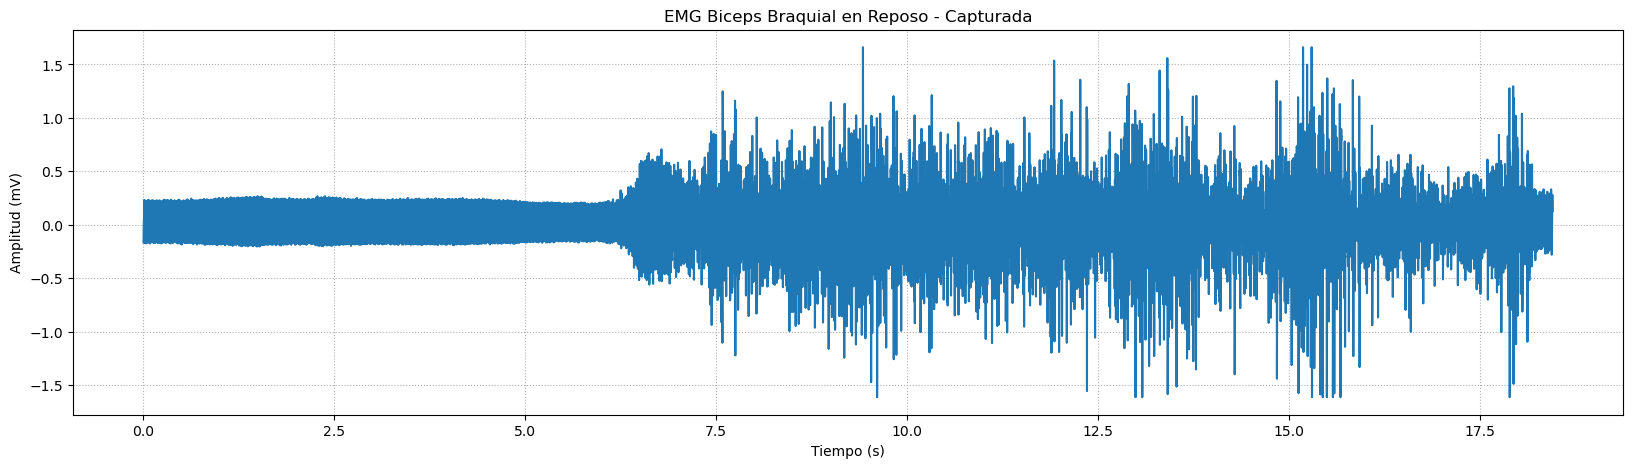

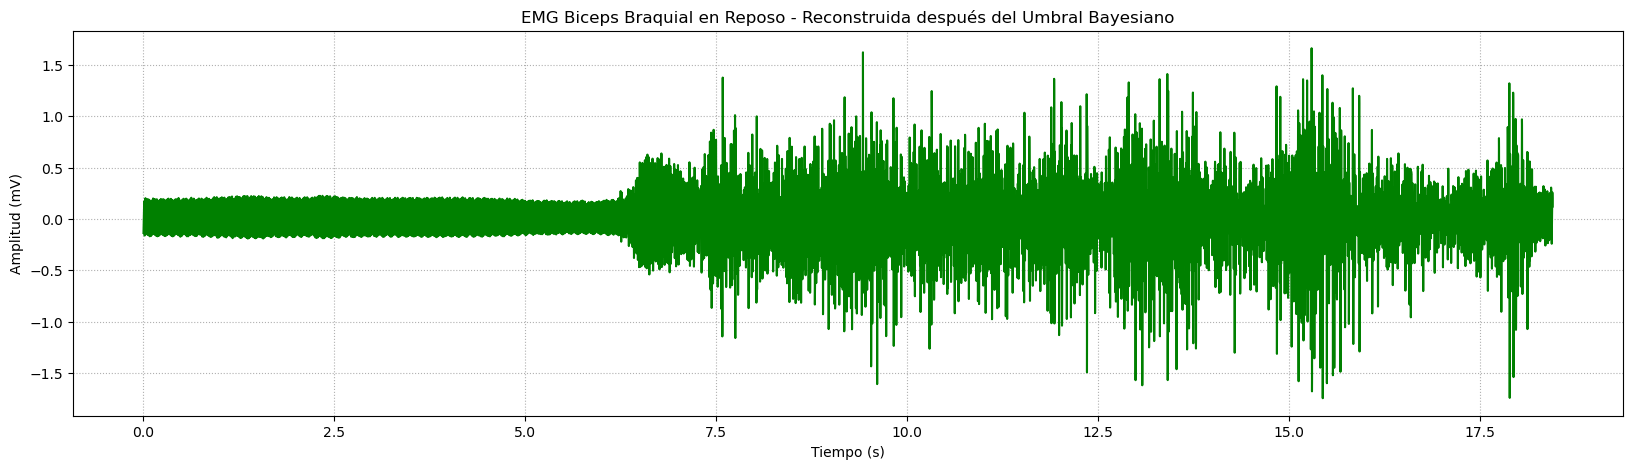

SNR: 14.90 dB
MSE: 0.0031
PSNR: 29.49 dB


In [36]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

#FUNCIONES

#Relación señal - ruido
def calculate_snr(signal, noise):
    #Para hallar la relación entre señal y ruido es necesario su uso
    power_signal = np.sum(signal ** 2) / len(signal)
    power_noise = np.sum(noise ** 2) / len(noise)
    snr = 10 * np.log10(power_signal / power_noise)
    return snr

#MSE (Error Cuadrático Medio)
def calculate_mse(original_signal, reconstructed_signal):
    mse = np.mean((original_signal - reconstructed_signal) ** 2)
    return mse

#PSNR (Relación senal a Ruido de Pico)
#
def calculate_psnr(original_signal, reconstructed_signal):
    mse = calculate_mse(original_signal, reconstructed_signal)
    if mse == 0:  # Evitar división por cero
        return float('inf')
    max_value = np.max(original_signal)  # Valor máximo de la señal
    psnr = 10 * np.log10((max_value ** 2) / mse)
    return psnr

#VISTA --------------------------------------------------------------
bits = 10 # Bits de la salida 
volt_range = 3.28 #Rango de voltaje en milivoltios (-1.64; 1.64) mV

#Extracción la penultima columna (datos)
y_1 = (a_r[: ,-2] * volt_range/(2**bits - 1)) # convertir los bits a mV
y_1 = y_1 - np.mean(y_1) # Centrar la señal, ya que va de -1.64 a 1.64
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo
#-------------------------------------------------------------------


#Función para aplicar el umbral suave
def soft_thresholding(data, threshold):
    return np.sign(data) * np.maximum(np.abs(data) - threshold, 0)

#Función para calcular el umbral bayesiano
def bayesian_threshold(noise_var, signal_var):
    return noise_var / (noise_var + signal_var)

# Configuración de niveles y tipo de wavelet
niveles = 5
wavelet = 'db4' #Familia elejida #sym8

# Descomposición en niveles de wavelet
coeficientes = pywt.wavedec(y_1, wavelet, level=niveles)

#Estimación de la varianza del ruido a partir del último nivel de detalle
sigma = np.median(np.abs(coeficientes[-1])) / 0.6745  #Estimación del ruido basada en Gauss
noise_var = sigma ** 2

# Aplica el umbral bayesiano a los coeficientes de detalle
coeficientes_umbralados = coeficientes.copy()
for i in range(1, len(coeficientes)):  # Aplica el umbral solo a los coeficientes de detalle
    signal_var = np.var(coeficientes[i])  # Varianza de los coeficientes de la señal
    umbral_bayes = bayesian_threshold(noise_var, signal_var) * 2
    coeficientes_umbralados[i] = soft_thresholding(coeficientes[i], umbral_bayes)

# Reconstrucción de la señal a partir de los coeficientes umbralados
señal_reconstruida = pywt.waverec(coeficientes_umbralados, wavelet)

# Graficar la señal original y la señal reconstruida

# Gráfico de la señal original
plt.figure(figsize=(20, 5))#; plt.xlim(10, 11)
plt.plot(t_1, y_1, label="Señal Original")
plt.title("EMG Biceps Braquial en Reposo - Capturada")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
#plt.savefig("EMG1_1.png", format='png')
plt.show()

# Gráfico de la señal reconstruida (denoised con umbral bayesiano)
plt.figure(figsize=(20, 5))#; plt.xlim(10, 11)
plt.plot(t_1, señal_reconstruida[:len(t_1)], label="Señal Reconstruida (Denoised con Umbral Bayesiano)", color='green')
plt.title("EMG Biceps Braquial en Reposo - Reconstruida después del Umbral Bayesiano")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
#plt.savefig("EMG1_2.png", format='png')
# Mostrar los gráficos
plt.show()

# Calcular SNR, MSE y PSNR
snr_val = calculate_snr(y_1, y_1 - señal_reconstruida[:len(t_1)])
mse_val = calculate_mse(y_1, señal_reconstruida[:len(t_1)])
psnr_val = calculate_psnr(y_1, señal_reconstruida[:len(t_1)])

# Mostrar los valores
print(f"SNR: {snr_val:.2f} dB")
print(f"MSE: {mse_val:.4f}")
print(f"PSNR: {psnr_val:.2f} dB")


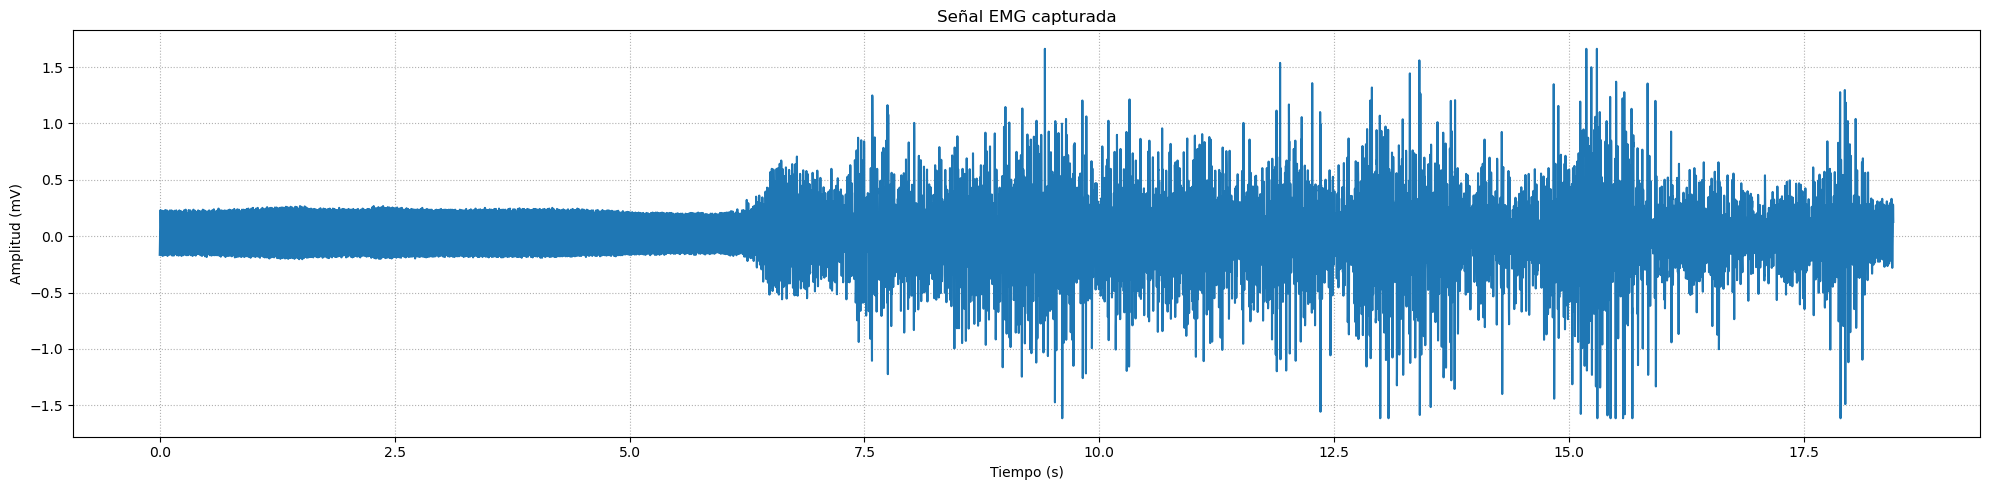

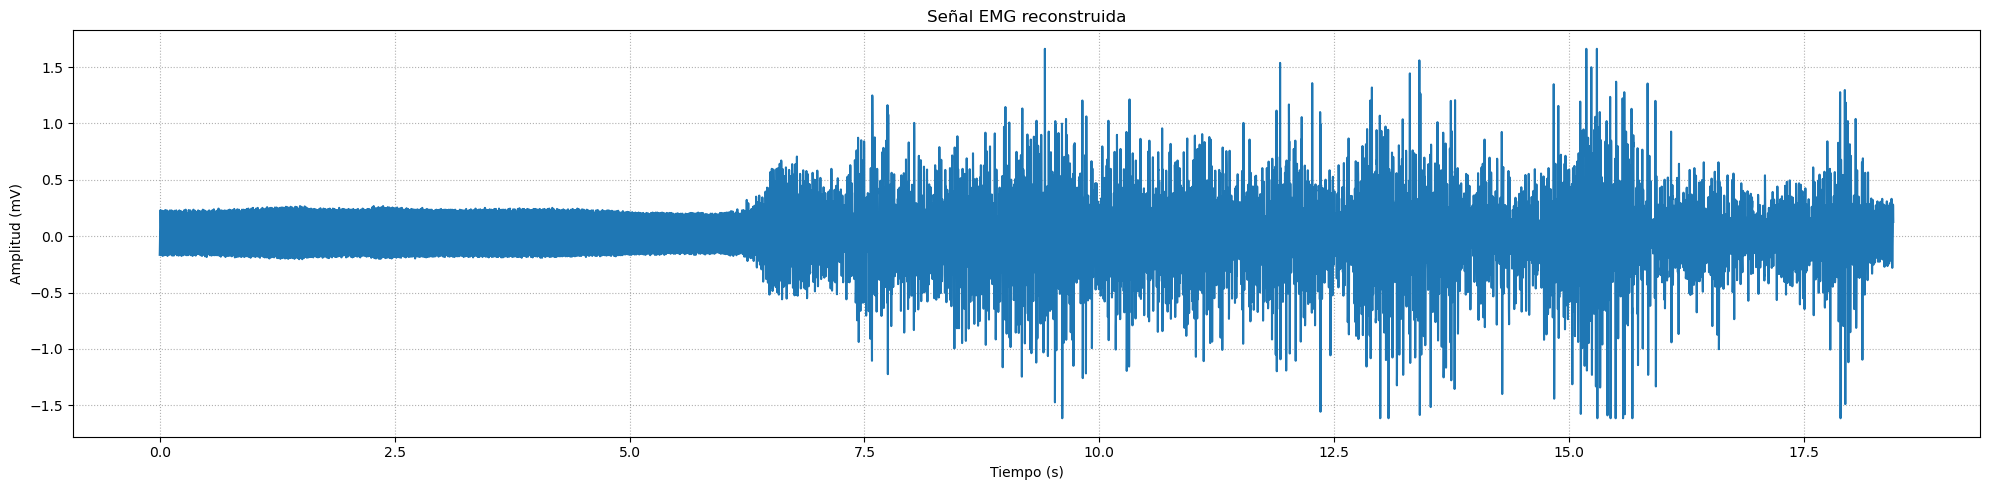

In [5]:
#WAVELET (DWT) -------------------------------------------------------------
#Uso por literatura
niveles = 5
coeficientes = pywt.wavedec(y_1, 'sym8', level=niveles)

# Graficar la señal original y los coeficientes de detalle y de aproximación
plt.figure(figsize=(20, 5))

# Graficar la señal original
plt.plot(t_1, y_1, label="señal")  # Señal completa
plt.title("Señal EMG capturada")
plt.grid(linestyle=":")  # Cuadrícula punteada
plt.xlabel("Tiempo (s)") 
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Reconstrucción de la señal a partir de los coeficientes (solo aproximación)
señal_reconstruida = pywt.waverec(coeficientes, 'sym8')

# Graficar la señal reconstruida
plt.figure(figsize=(20, 5))
plt.plot(t_1, señal_reconstruida[:len(t_1)], label="Señal reconstruida")
plt.title("Señal EMG reconstruida")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)") 
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Mostrar todos los gráficos
plt.show()


In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Función para aplicar el umbral duro (hard thresholding)
def hard_thresholding(data, threshold):
    return data * (np.abs(data) > threshold)

# Función para calcular el umbral bayesiano
def bayesian_threshold(noise_var, signal_var):
    """Calcula el umbral bayesiano."""
    return noise_var / (noise_var + signal_var)

# Configuración de niveles y tipo de wavelet
niveles = 5
wavelet = 'sym8'

# Descomposición en niveles de wavelet
coeficientes = pywt.wavedec(y_1, wavelet, level=niveles)

# Estimación de la varianza del ruido a partir del último nivel de detalle
sigma = np.median(np.abs(coeficientes[-1])) / 0.6745  # Estimación del ruido
noise_var = sigma ** 2

# Aplica el umbral bayesiano a los coeficientes de detalle usando hard thresholding
coeficientes_umbralados = coeficientes.copy()
for i in range(1, len(coeficientes)):  # Aplica el umbral solo a los coeficientes de detalle
    signal_var = np.var(coeficientes[i])  # Varianza de los coeficientes de la señal
    umbral_bayes = bayesian_threshold(noise_var, signal_var)
    coeficientes_umbralados[i] = hard_thresholding(coeficientes[i], umbral_bayes)

# Reconstrucción de la señal a partir de los coeficientes umbralados
señal_reconstruida = pywt.waverec(coeficientes_umbralados, wavelet)

# Graficar la señal original y la señal reconstruida

# Gráfico de la señal original
plt.figure(figsize=(20, 5)); plt.xlim(11,12)
plt.plot(t_1, y_1, label="Señal Original")
plt.title("Señal EMG capturada")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Gráfico de la señal reconstruida (denoised con umbral bayesiano - hard thresholding)
plt.figure(figsize=(20, 5)); plt.xlim(11,12)
plt.plot(t_1, señal_reconstruida[:len(t_1)], label="Señal Reconstruida (Denoised con Umbral Bayesiano - Hard Thresholding)", color='green')
plt.title("Señal EMG reconstruida después del umbral bayesiano (Hard Thresholding)")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Mostrar los gráficos
plt.show()



NameError: name 'y_1' is not defined

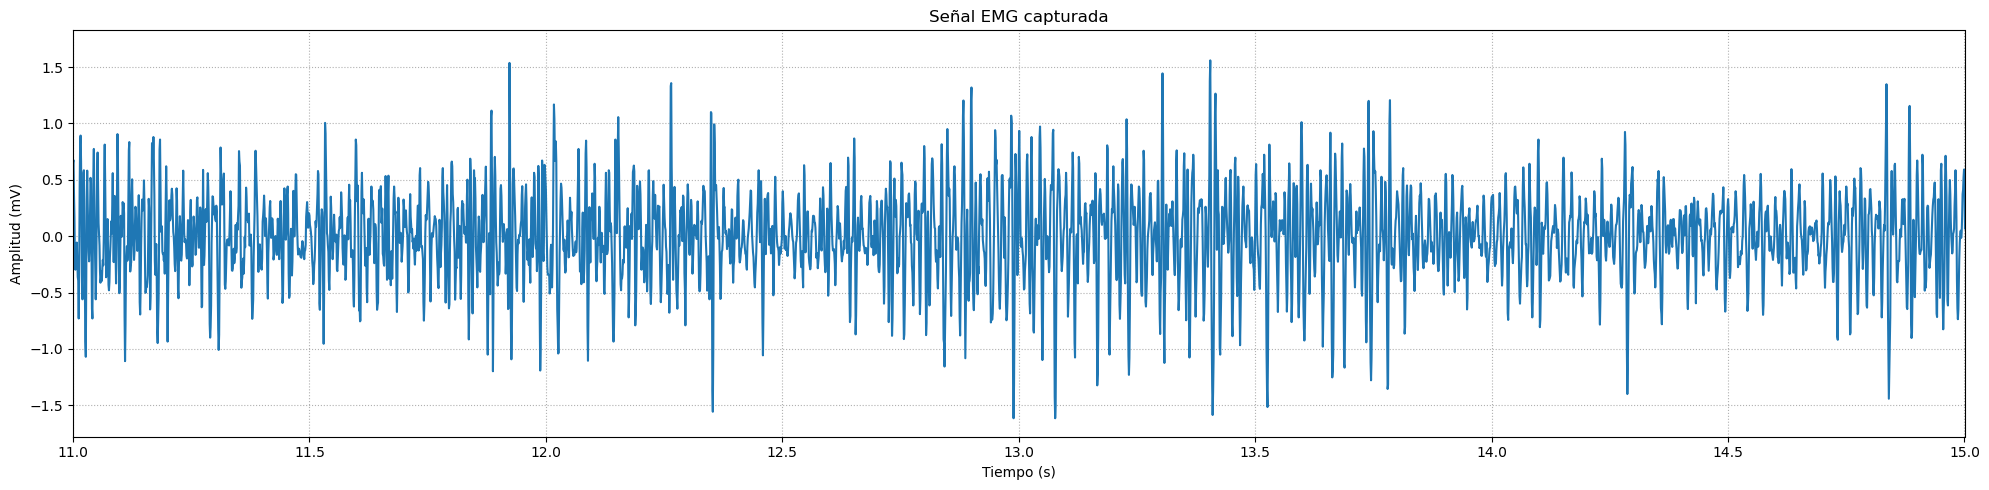

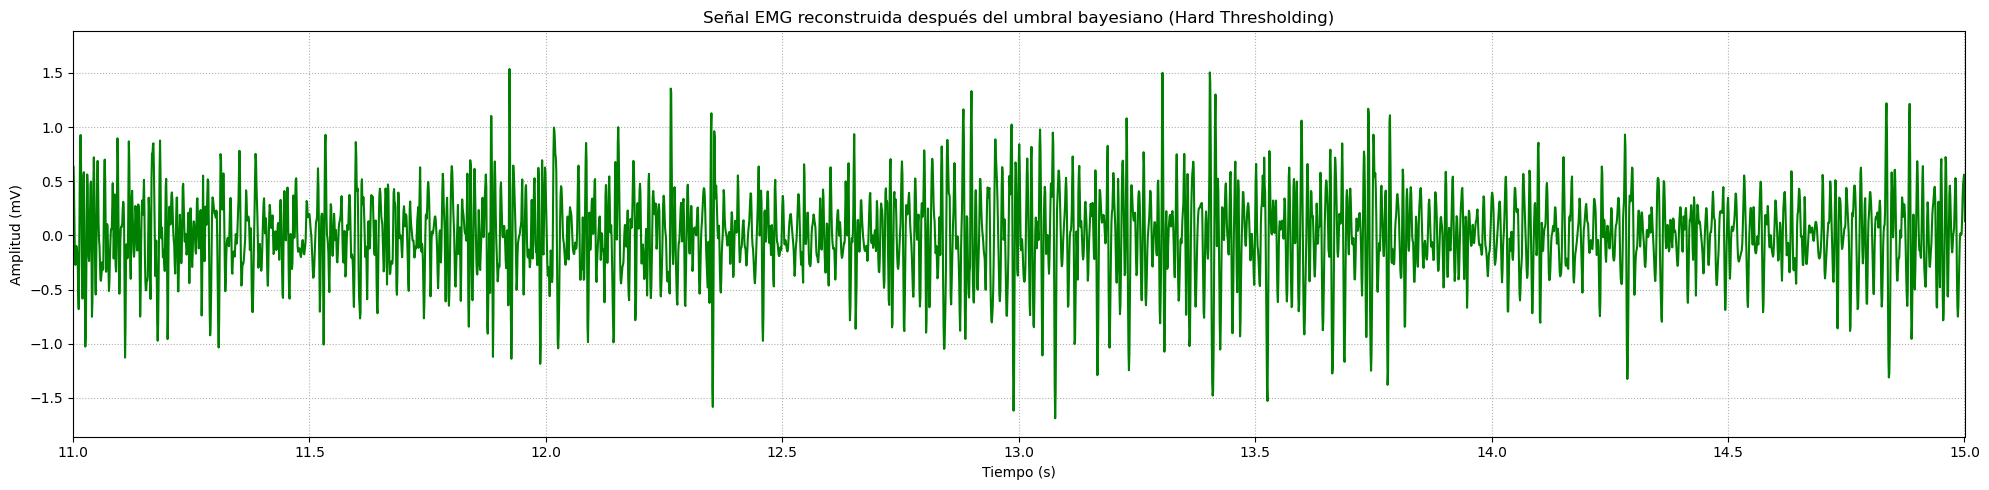

In [69]:
import numpy as np
import pywt
import matplotlib.pyplot as plt

# Función para aplicar el umbral duro (hard thresholding)
def hard_thresholding(data, threshold):
    return data * (np.abs(data) > threshold)

# Función para calcular el umbral bayesiano
def bayesian_threshold(noise_var, signal_var):
    """Calcula el umbral bayesiano."""
    return noise_var / (noise_var + signal_var)

# Configuración de niveles y tipo de wavelet
niveles = 10
wavelet = 'sym8'

# Asegúrate de que t_1 y y_1 estén definidos
# Descomposición en niveles de wavelet
coeficientes = pywt.wavedec(y_1, wavelet, level=niveles)

# Estimación de la varianza del ruido a partir del último nivel de detalle
sigma = np.median(np.abs(coeficientes[-1])) / 0.6745  # Estimación del ruido
noise_var = sigma ** 2

# Aplica el umbral bayesiano a los coeficientes de detalle usando hard thresholding
coeficientes_umbralados = coeficientes.copy()
for i in range(1, len(coeficientes)):  # Aplica el umbral solo a los coeficientes de detalle
    signal_var = np.var(coeficientes[i])  # Varianza de los coeficientes de la señal
    umbral_bayes = bayesian_threshold(noise_var, signal_var)
    coeficientes_umbralados[i] = hard_thresholding(coeficientes[i], umbral_bayes)

# Reconstrucción de la señal a partir de los coeficientes umbralados
señal_reconstruida = pywt.waverec(coeficientes_umbralados, wavelet)

# Ajustar la longitud de la señal reconstruida si es necesario
señal_reconstruida = señal_reconstruida[:len(t_1)]

# Graficar la señal original y la señal reconstruida

# Gráfico de la señal original
plt.figure(figsize=(20, 5))
plt.xlim(11,15)
plt.plot(t_1, y_1, label="Señal Original")
plt.title("Señal EMG capturada")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Gráfico de la señal reconstruida (denoised con umbral bayesiano - hard thresholding)
plt.figure(figsize=(20, 5))
plt.xlim(11,15)
plt.plot(t_1, señal_reconstruida, label="Señal Reconstruida (Denoised con Umbral Bayesiano - Hard Thresholding)", color='green')
plt.title("Señal EMG reconstruida después del umbral bayesiano (Hard Thresholding)")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (mV)")
plt.tight_layout()

# Mostrar los gráficos
plt.show()
